# day 208

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import tensorflow as tf
import zipfile
import os
import requests
import matplotlib.image as image
import tensorflow_datasets

# goal1:
Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [ ]:
# downloading and unzipping the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

--2023-10-18 13:49:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 108.177.97.207, 108.177.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  31.1MB/s    in 6.1s    

2023-10-18 13:50:05 (26.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# train test splitting and data augmentation
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         label_mode='int',
                                                         seed=42)


test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=(224,224),
                                                        batch_size=32,
                                                        label_mode='int',
                                                        seed=42)

# data augmentation:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# creating the ModelCheckpoint callback
def ModelCheckpoint(experiment_name):
  filepath = 'ModelsCheckpoint/' + experiment_name

  mcp = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           save_freq='epoch')

  return mcp




In [ ]:
# creating the feature extractor model

'''include_top = False is because we are extracting only the features of the model and pattern the model was trained
on is not needful so, we do not include the layers near the output which are specialized to detect patterns it was
trained on'''
base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# we don't want to train the model
base.trainable = False

# input layer
input_layer = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# data augmentation on input layer
x = data_augmentation(input_layer)

# insertig the above layer into base_model
x = base(x)

# Global Average Pooling 2D
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# output layer
output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# feature_extractor layer
feature_extractor = tf.keras.Model(input_layer,output_layer)


# compiling the feature extractor
feature_extractor.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics='accuracy')

# fit the model
tf.random.set_seed(42)
feature_extractor_epoch = 10
history0 = feature_extractor.fit(train_data,
                      epochs=feature_extractor_epoch,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[ModelCheckpoint('feature_extractor')])

Epoch 1/10
24/24 [==============================] - 26s 540ms/step - loss: 2.0491 - accuracy: 0.3253 - val_loss: 1.5761 - val_accuracy: 0.6012
Epoch 2/10
24/24 [==============================] - 7s 284ms/step - loss: 1.4558 - accuracy: 0.6173 - val_loss: 1.1712 - val_accuracy: 0.7200
Epoch 3/10
24/24 [==============================] - 8s 329ms/step - loss: 1.1578 - accuracy: 0.7213 - val_loss: 0.9351 - val_accuracy: 0.7704
Epoch 4/10
24/24 [==============================] - 8s 338ms/step - loss: 1.0070 - accuracy: 0.7280 - val_loss: 0.7957 - val_accuracy: 0.8060
Epoch 5/10
24/24 [==============================] - 8s 346ms/step - loss: 0.8800 - accuracy: 0.7893 - val_loss: 0.7239 - val_accuracy: 0.8144
Epoch 6/10
24/24 [==============================] - 7s 304ms/step - loss: 0.8213 - accuracy: 0.7920 - val_loss: 0.6556 - val_accuracy: 0.8260
Epoch 7/10
24/24 [==============================] - 8s 291ms/step - loss: 0.7460 - accuracy: 0.8067 - val_loss: 0.6143 - val_accuracy: 0.8352
Epoch

# goal 2
Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
# fine-tuning the top 20 layers of the model

base.trainable = True

for layer in base.layers[:-20]:
  layer.trainable = False

# recompile the feature_extractor after we fine-tuned few layers
feature_extractor.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])

# fit the model
tf.random.set_seed(42)
fine_tuning_epochs = feature_extractor_epoch + 10
history1 = feature_extractor.fit(train_data,
                                 epochs=fine_tuning_epochs,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 initial_epoch=history0.epoch[-1]+1,
                                 callbacks=[ModelCheckpoint('fine_tuned_model')])

Epoch 11/20
24/24 [==============================] - 22s 406ms/step - loss: 0.7597 - accuracy: 0.7987 - val_loss: 0.4447 - val_accuracy: 0.8508
Epoch 12/20
24/24 [==============================] - 8s 322ms/step - loss: 0.4580 - accuracy: 0.8733 - val_loss: 0.4096 - val_accuracy: 0.8672
Epoch 13/20
24/24 [==============================] - 8s 329ms/step - loss: 0.3744 - accuracy: 0.8933 - val_loss: 0.3885 - val_accuracy: 0.8684
Epoch 14/20
24/24 [==============================] - 8s 332ms/step - loss: 0.2819 - accuracy: 0.9253 - val_loss: 0.3720 - val_accuracy: 0.8744
Epoch 15/20
24/24 [==============================] - 7s 276ms/step - loss: 0.2408 - accuracy: 0.9347 - val_loss: 0.3825 - val_accuracy: 0.8764
Epoch 16/20
24/24 [==============================] - 8s 318ms/step - loss: 0.1735 - accuracy: 0.9600 - val_loss: 0.3847 - val_accuracy: 0.8692
Epoch 17/20
24/24 [==============================] - 12s 510ms/step - loss: 0.1517 - accuracy: 0.9680 - val_loss: 0.3813 - val_accuracy: 0.87

# goal 3:
Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
# fine_tune the top 30 layers
base.trainable = True

# freezing all other layers and releasing only the top 30 layers to be fine-tuned with custom data
for layer in base.layers[:-30]:
  layer.trainable = False


# recompiling
feature_extractor.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=['accuracy'])

# fitting the model
tf.random.set_seed(42)

feature_extractor.fit(train_data,
                      epochs=fine_tuning_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      initial_epoch=history0.epoch[-1]+1,
                      callbacks=ModelCheckpoint('fine_tuned_model_30_layers'))


Epoch 11/20
24/24 [==============================] - 22s 401ms/step - loss: 0.1209 - accuracy: 0.9733 - val_loss: 0.3626 - val_accuracy: 0.8884
Epoch 12/20
24/24 [==============================] - 8s 298ms/step - loss: 0.1035 - accuracy: 0.9813 - val_loss: 0.3562 - val_accuracy: 0.8840
Epoch 13/20
24/24 [==============================] - 7s 298ms/step - loss: 0.0938 - accuracy: 0.9813 - val_loss: 0.3504 - val_accuracy: 0.8876
Epoch 14/20
24/24 [==============================] - 7s 275ms/step - loss: 0.0719 - accuracy: 0.9840 - val_loss: 0.3508 - val_accuracy: 0.8848
Epoch 15/20
24/24 [==============================] - 8s 294ms/step - loss: 0.0839 - accuracy: 0.9827 - val_loss: 0.3540 - val_accuracy: 0.8828
Epoch 16/20
24/24 [==============================] - 8s 319ms/step - loss: 0.0765 - accuracy: 0.9880 - val_loss: 0.3510 - val_accuracy: 0.8860
Epoch 17/20
24/24 [==============================] - 7s 268ms/step - loss: 0.0610 - accuracy: 0.9933 - val_loss: 0.3513 - val_accuracy: 0.887

# goal 4:
Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

1/1 [==============================] - 0s 26ms/step


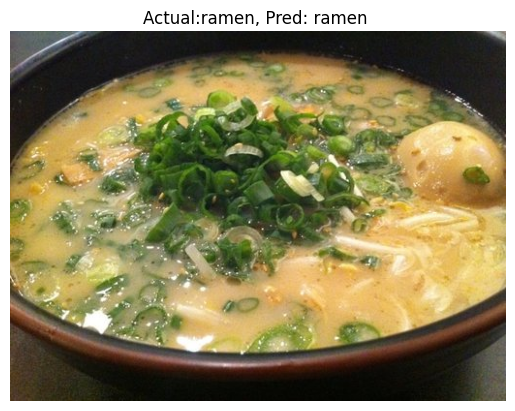

In [ ]:
dir = '10_food_classes_10_percent/test'


random_class = np.random.choice(os.listdir(dir))
random_image = np.random.choice(os.listdir(dir + '/' + random_class))
img_to_numbers = image.imread(dir + '/' + random_class + '/' + random_image)

# plotting the image
plt.imshow(img_to_numbers)


# preprocessing the image
# reshape it to 224,224,3 and add an extra dimension

resized_image = tf.image.resize(img_to_numbers,(224,224))
expanded_image = tf.expand_dims(resized_image,axis=0)
prediction = feature_extractor.predict(expanded_image)
class_names = sorted(os.listdir(dir))
prediction_label = class_names[tf.argmax(prediction,axis=1)[0]]


plt.title('Actual:{}, Pred: {} '.format(random_class,prediction_label))
plt.axis('off')

plt.show()

# EC1:
Read the documentation on data augmentation in TensorFlow. and summarize it here:


# study about parallelism:
* [[parallelism]] is about having the computational architectures stacked parallely to reduce the time of computation and increase the speed of execution.
----------
* it can be extremely useful for processing for large databases of images and videos in a short time.
---------
* A best tool for [[computer vision]]


# study about AUTOTUNE:
* [[AUTOTUNING]] is about adjusting the paramters of system to the needs and necessity of the situation and environment.
--------
* In [[computer vision]] algorithms it automatically adjusts or reconfigures the parameters to needs of the situation without manually a person having to supervise and modify.

# study about prefetch and I/O blocking:
* [[prefetching]] is a risk aversive technique and also an extremely useful optimization technique.
-----
* it rightfully stands for the proverb "An ounce of prevention is worth a pound of cure" which means avert the danger before it is even a danger.
---------
* it is based on the idea of fetching from disk something and keeping it in store before sending the thing for processing to kernel. since we have already fetched it, we don't have to deal with I/O errors every now and then we need that data to be taken for processing in the kernel.
--------------
* In the context of [[computer vision]], dealing with a large swaths of images would surely dampen the time of taking something from the disk everytime, so having the data prefetched is an extremely important optimization technique.
---------
* In computer vision, I/O blocking can refer to the delays or interruptions caused by input/output operations during the processing of visual data. Excessive I/O blocking can lead to slower data access and transfer rates, impeding the real-time analysis and interpretation of visual information. To mitigate the impact of I/O blocking in computer vision applications, optimized data management techniques, efficient data caching strategies, and streamlined I/O operations can be implemented to ensure smooth and uninterrupted data processing, enabling faster and more responsive image analysis and recognition.


# making the preprocessing layers part of your model:

### part 1: make the preprocessing a part of your model:

#### benefits are:
* i don't have to deal with preprocessing and doing data augmentation on my images everytime i insert them into the models for making predictions.
-------
* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
-----------
* When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.


# part 2:
* With this approach, you use Dataset.map to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.

* In this case the preprocessing layers will not be exported with the model when you call Model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

train_data.map(lambda x,y: rescale_and_reshaping(x),y).


# when to set tf.keras.SparseCategoricalCrossentropy(from_logits=True)?
* when you haven't used softmax activation function or sigmoid activation for binary the model's output would be raw logits meaning they are normalized probabilities as would have been the case with using softmax or sigmoid activation function on the output layers.
* expecting a raw logit from a model can also be useful in certain scenario where you want an un-normalized non-proablistic output from the model for further information addition or modification with the output that you intend to do.



# day 213

# EC2:

# UNIVERSAL LANGUAGE MODEL FINE-TUNING FOR TEXT CLASSIFICATION(ULMFIT):
* training from scratch is highly inefficient and high loss producing hence is this model developed by jeremy from San Francisco and sebastian from Dublin. This model is better than training a model from scratch with 100x more data.

# usefulness and application of UNIVERSAL LANGUAGE MODEL FINE-TUNING:
* it is useful for natural language processing tasks.

# methods discussed in the article:
* discriminative fine-tuning.
* slanted triangular learning rate.
* gradual unfreezing.

# End goal:
* **RETAIN PREVIOUS KNOWLEDGE AND AVOID FORGETTING EVERYTING EVERYTIME.**

# meaning of ablation analysis:
* Remove from the system each component one by one and understand how each contributed to the functioning of the whole.

# understanding of layers in Computer vision deep neural networks:
* first layers are more generalizable and towards the end or the output layer are more task-specific.
* in compute vision tasks we freeze those first few layers and make those last few layers trainable to find patterns in custom data.

# NLP:

* TF: term frequency counts the number of times a word has been used in a document.
* IDF: inverse document frequency counts the rarity of words (how less often a word has occurred). Rarely used words may have more significance.

# Hypercolumns:
Word embeddings are a way of representing words as vectors of numbers. These vectors are learned from a large corpus of text, and they capture the semantic and syntactic relationships between words. For example, the word embeddings for the words "king" and "queen" would be very similar, because these words have similar meanings.

    # word embeddings:
    Word2Vec: Word2Vec is a popular algorithm for training word embeddings.
    It learns word embeddings by predicting the context of a word in a sentence.
    For example, the Word2Vec embedding for the word "king" might be similar to the embeddings for the words "queen", "monarch", and "royal".

    GloVe: GloVe is another popular algorithm for training word embeddings.
    It learns word embeddings by analyzing the global word-word co-occurrence statistics of a large corpus of text.
    For example, the GloVe embedding for the word "king" might be similar to the embeddings for the words "queen", "throne", and "crown".

    FastText: FastText is an extension of Word2Vec that can also capture subword information.
    This makes it useful for representing rare words and out-of-vocabulary words.
    For example, the FastText embedding for the word "kingly" might be similar to the embeddings for the words "king", "royal", and "ly".

Word embeddings have been very successful in many NLP tasks, such as machine translation and text classification. However, they can be limited in their ability to capture the context of a word in a sentence. For example, the word "bank" can refer to a financial institution or to the side of a river. Word embeddings alone cannot tell the difference between these two meanings.

Hypercolumns are a way to address this limitation. Hypercolumns combine word embeddings with other features that capture the context of a word in a sentence. For example, a hypercolumn for the word "bank" in the sentence "I went to the bank to deposit my paycheck" might include the word embeddings for the words "went", "to", "the", and "deposit", as well as the part-of-speech tags for these words.

Hypercolumns have been shown to improve the performance of NLP models on a variety of tasks, including machine translation, text classification, and question answering.

Here is a simpler explanation of the sentence:

In NLP, we used to just use word embeddings to represent words. This worked well, but it didn't capture the context of a word in a sentence. For example, the word "bank" can mean different things depending on the context.

Hypercolumns are a new way to represent words that captures the context of the word in a sentence. This helps NLP models to perform better on a variety of tasks, such as machine translation and text classification.


# Benefits of ULMFIT:
* We propose Universal Language Model Finetuning (ULMFiT), which pretrains a language
model (LM) on a large general-domain corpus and
fine-tunes it on the target task using novel techniques. The method is universal in the sense that
it meets these practical criteria:

1.  It works across
tasks varying in document size, number, and label
type;
2. it uses a single architecture and training
process;
3. it requires no custom feature engineering or preprocessing; and
4. it does not require additional in-domain documents or labels.


# Getter better and better and there is no end for improvisation:
* the transfer learning is about once we have a foundational layer making some predictions or classifications, we build on top of it the next upgrade and subsequent upgrades. each upgrade is going to be better than the previous and there is no end literally. the best part is we can use the model built with best available data by scientists in big institutions and companies to train the computer for our tasks.


# different learning for differnt layers:
* not all layers in the network will be treated the same, some with small learning rate and some with large learning based on whichever lets us converge to the ideal solution faster.
* this is known as slanted traiangular learning rate.

# aggressive fine-tuning leads to catostrophic forgetting of the patterns learned:
* Overly aggressive fine-tuning will cause catastrophic forgetting, eliminating the benefit of the information
captured through language modeling; too cautious
fine-tuning will lead to slow convergence (and resultant overfitting).
* Besides discriminative finetuning and triangular learning rates, we propose
gradual unfreezing for fine-tuning the classifier.
* **gradual unfreezing takes care of that forgetting problem**.


# summary:
* discriminative fine-tuning is: keeping some layers trainable and some layers frozen (untrainable). last few layers towards the  ouput are mostly made trainable on custom data than those generalizable first layers.
* slanted triangular learning rate is: changing the learning rate between each layers rather than keeping it static all the way down.
* gradually unfreezing the last layers is: we unfreeze few layers at the end gradually, lets say in the first training when doing feature extraction we made it all untrainable, the second time we unfreeze 5 layers towards the end, the third time we unfreeze five more layers adding total unfrozen layers to 10 layers, the fourth time 5 more and so on.



  





# EC3:

# learning rate decrement as we train for longer:
If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.